In [ ]:
# 1. First, download and prepare the dataset
!gdown https://drive.google.com/uc?id=1O05QqQKUDLBi89dTUqTmf_SwBtsXkT1E
!mkdir -p 'wear'
!unzip -oq tribology_dataset.zip -d wear
!rm tribology_dataset.zip


Downloading...
From: https://drive.google.com/uc?id=1O05QqQKUDLBi89dTUqTmf_SwBtsXkT1E
To: /content/tribology_dataset.zip
100% 15.6M/15.6M [00:00<00:00, 41.8MB/s]


In [ ]:
# Import necessary libraries
import os
import csv
import copy
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

In [ ]:
# 1. Data Preparation and Split
def build_csv(directory_string, output_csv_name):
    class_list = os.listdir(directory_string)
    class_list.sort()
    with open(output_csv_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index'])
        for class_name in class_list:
            class_path = os.path.join(directory_string, class_name)
            file_list = os.listdir(class_path)
            for file_name in file_list:
                file_path = os.path.join(directory_string, class_name, file_name)
                writer.writerow([file_name, file_path, class_name, class_name.split("_")[1]])
    return

directory_string = os.path.join(os.getcwd(), 'wear')
build_csv(directory_string, 'train.csv')
train_df = pd.read_csv('train.csv')

# Split dataset into train, validation, and test sets
train_val_idx, test_idx = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['class_index'],
    random_state=42
)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.2,
    stratify=[train_df['class_index'][i] for i in train_val_idx],
    random_state=42
)

# Dataset size information
print("Dataset Distribution:")
print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

def print_class_distribution():
    for dataset_name, indices in [("Train", train_idx), ("Validation", val_idx), ("Test", test_idx)]:
        class_counts = {}
        for idx in indices:
            label = train_df['class_index'][idx]
            class_counts[label] = class_counts.get(label, 0) + 1
        print(f"\n{dataset_name} set class distribution:")
        print(class_counts)

print_class_distribution()

# Custom Dataset class
class tribologyDataset(Dataset):
    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        class_name = self.annotation_df.iloc[idx, 2]
        class_index = self.annotation_df.iloc[idx, 3]
        return image, class_name, class_index

# Define DataLoader with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    transforms.Grayscale(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast()
])

train_dataset = tribologyDataset(csv_file='train.csv', root_dir="", transform=transform)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(train_dataset, batch_size=10, sampler=train_sampler, num_workers=2)
val_dataloader = DataLoader(train_dataset, batch_size=10, sampler=val_sampler, num_workers=2)
test_dataloader = DataLoader(train_dataset, batch_size=10, sampler=test_sampler, num_workers=2)

Dataset Distribution:
Train set size: 320
Validation set size: 80
Test set size: 100

Train set class distribution:
{4: 64, 1: 64, 3: 64, 0: 64, 2: 64}

Validation set class distribution:
{1: 16, 2: 16, 3: 16, 4: 16, 0: 16}

Test set class distribution:
{2: 20, 3: 20, 0: 20, 1: 20, 4: 20}


In [ ]:
# 2. Model Definition
class VGG_BatchNormTorch(nn.Module):
    def __init__(self, in_channels, out_features):
        super(VGG_BatchNormTorch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm2 = torch.nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm3 = torch.nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm4 = torch.nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5 = torch.nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6 = torch.nn.BatchNorm2d(128)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=128, out_features=out_features)

    def forward(self, x):
        x = self.norm1(self.conv1(x))
        x = F.relu(x)
        x = self.norm2(self.conv2(x))
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.norm3(self.conv3(x))
        x = F.relu(x)
        x = self.norm4(self.conv4(x))
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.norm5(self.conv5(x))
        x = F.relu(x)
        x = self.norm6(self.conv6(x))
        x = F.relu(x)
        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [ ]:
# 3. Training and Evaluation Functions
def train(model, train_loader, val_loader, criterion, optimizer, n_epoch):
    best_val_acc = 0
    best_model = None
    history = {'train_loss': [], 'val_acc': []}
    for epoch in range(n_epoch):
        model.train()
        running_loss = 0
        for i, (images, _, labels) in enumerate(train_loader):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, _, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct / val_total
        history['val_acc'].append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Val Acc: {val_acc:.2f}%')
    return best_model, history

def evaluate_ensemble(models, dataloader):
    for model in models:
        model.eval()
    all_labels = []
    all_predictions = []
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    correctly_classified_images = {i: [] for i in range(5)}  # Assuming 5 classes

    with torch.no_grad():
        for images, _, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = torch.zeros(len(labels), 5).cuda()
            for model in models:
                outputs += model(images)
            outputs /= len(models)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                image_tensor = images[i].cpu()
                image_np = image_tensor.numpy()
                if image_np.shape[0] == 1:
                    image_np = image_np.squeeze(0)
                elif image_np.shape[0] == 3:
                    image_np = image_np.transpose(1, 2, 0)

                if labels[i] != predicted[i]:
                    misclassified_images.append(image_np)
                    misclassified_labels.append(labels[i].item())
                    misclassified_predictions.append(predicted[i].item())
                else:
                    if len(correctly_classified_images[labels[i].item()]) < 5:
                        correctly_classified_images[labels[i].item()].append(image_np)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return accuracy, precision, recall, f1, misclassified_images, misclassified_labels, misclassified_predictions, correctly_classified_images

def plot_confusion_matrix(models, dataloader, title):
    all_labels = []
    all_predictions = []
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    correctly_classified_images = {i: [] for i in range(5)}  # Assuming 5 classes

    with torch.no_grad():
        for images, _, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = torch.zeros(len(labels), 5).cuda()
            for model in models:
                outputs += model(images)
            outputs /= len(models)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                image_tensor = images[i].cpu()
                image_np = image_tensor.numpy()
                if image_np.shape[0] == 1:
                    image_np = image_np.squeeze(0)
                elif image_np.shape[0] == 3:
                    image_np = image_np.transpose(1, 2, 0)

                if labels[i] != predicted[i]:
                    misclassified_images.append(image_np)
                    misclassified_labels.append(labels[i].item())
                    misclassified_predictions.append(predicted[i].item())
                else:
                    if len(correctly_classified_images[labels[i].item()]) < 5:
                        correctly_classified_images[labels[i].item()].append(image_np)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot misclassified images
    if misclassified_images:
        cols = min(5, len(misclassified_images))
        rows = (len(misclassified_images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        plt.tight_layout(pad=3.0)
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, image in enumerate(misclassified_images):
            axes[i].imshow(image, cmap='gray' if image.ndim == 2 else None)
            axes[i].axis('off')
            axes[i].set_title(f'True: {misclassified_labels[i]}, Pred: {misclassified_predictions[i]}')

        for i in range(len(misclassified_images), len(axes)):
            axes[i].axis('off')

        plt.suptitle('Misclassified Images', fontsize=14)
        plt.show()

    # Plot correctly classified images by class
    for class_label, images in correctly_classified_images.items():
        if images:
            cols = min(5, len(images))
            rows = (len(images) + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
            plt.tight_layout(pad=3.0)
            axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

            for i, image in enumerate(images):
                axes[i].imshow(image, cmap='gray' if image.ndim == 2 else None)
                axes[i].axis('off')
                axes[i].set_title(f'Class {class_label}')

            for i in range(len(images), len(axes)):
                axes[i].axis('off')

            plt.suptitle(f'Representative Images for Class {class_label}', fontsize=14)
            plt.show()

    return cm

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()


Epoch 1, Loss: 1.286, Val Acc: 40.00%
Epoch 2, Loss: 1.110, Val Acc: 55.00%
Epoch 3, Loss: 1.019, Val Acc: 56.25%
Epoch 4, Loss: 0.946, Val Acc: 66.25%
Epoch 5, Loss: 0.906, Val Acc: 36.25%
Epoch 6, Loss: 0.862, Val Acc: 57.50%
Epoch 7, Loss: 0.762, Val Acc: 53.75%
Epoch 8, Loss: 0.726, Val Acc: 57.50%
Epoch 9, Loss: 0.671, Val Acc: 77.50%
Epoch 10, Loss: 0.782, Val Acc: 66.25%
Epoch 11, Loss: 0.639, Val Acc: 30.00%
Epoch 12, Loss: 0.578, Val Acc: 70.00%
Epoch 13, Loss: 0.576, Val Acc: 73.75%
Epoch 14, Loss: 0.511, Val Acc: 82.50%
Epoch 15, Loss: 0.529, Val Acc: 65.00%
Epoch 16, Loss: 0.509, Val Acc: 76.25%
Epoch 17, Loss: 0.492, Val Acc: 40.00%
Epoch 18, Loss: 0.400, Val Acc: 90.00%
Epoch 19, Loss: 0.388, Val Acc: 85.00%
Epoch 20, Loss: 0.373, Val Acc: 77.50%
Epoch 21, Loss: 0.394, Val Acc: 78.75%
Epoch 22, Loss: 0.427, Val Acc: 70.00%
Epoch 23, Loss: 0.352, Val Acc: 73.75%
Epoch 24, Loss: 0.408, Val Acc: 73.75%
Epoch 25, Loss: 0.384, Val Acc: 82.50%
Epoch 26, Loss: 0.358, Val Acc: 86

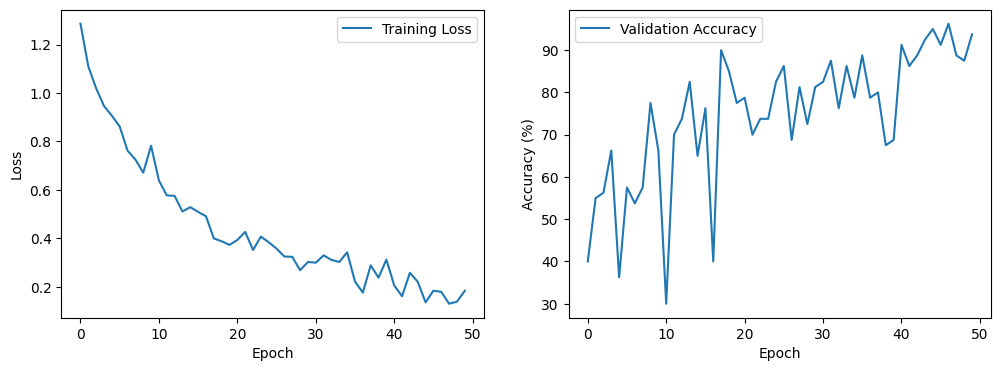

Epoch 1, Loss: 1.313, Val Acc: 33.75%
Epoch 2, Loss: 1.115, Val Acc: 46.25%
Epoch 3, Loss: 1.084, Val Acc: 48.75%
Epoch 4, Loss: 0.940, Val Acc: 65.00%
Epoch 5, Loss: 0.925, Val Acc: 65.00%
Epoch 6, Loss: 0.896, Val Acc: 71.25%
Epoch 7, Loss: 0.898, Val Acc: 47.50%
Epoch 8, Loss: 0.800, Val Acc: 71.25%
Epoch 9, Loss: 0.609, Val Acc: 73.75%
Epoch 10, Loss: 0.649, Val Acc: 48.75%
Epoch 11, Loss: 0.612, Val Acc: 91.25%
Epoch 12, Loss: 0.513, Val Acc: 70.00%
Epoch 13, Loss: 0.580, Val Acc: 80.00%
Epoch 14, Loss: 0.535, Val Acc: 83.75%
Epoch 15, Loss: 0.581, Val Acc: 45.00%
Epoch 16, Loss: 0.463, Val Acc: 70.00%
Epoch 17, Loss: 0.393, Val Acc: 71.25%
Epoch 18, Loss: 0.509, Val Acc: 76.25%
Epoch 19, Loss: 0.468, Val Acc: 86.25%
Epoch 20, Loss: 0.395, Val Acc: 66.25%
Epoch 21, Loss: 0.373, Val Acc: 81.25%
Epoch 22, Loss: 0.370, Val Acc: 83.75%
Epoch 23, Loss: 0.339, Val Acc: 86.25%
Epoch 24, Loss: 0.349, Val Acc: 93.75%
Epoch 25, Loss: 0.271, Val Acc: 85.00%
Epoch 26, Loss: 0.312, Val Acc: 63

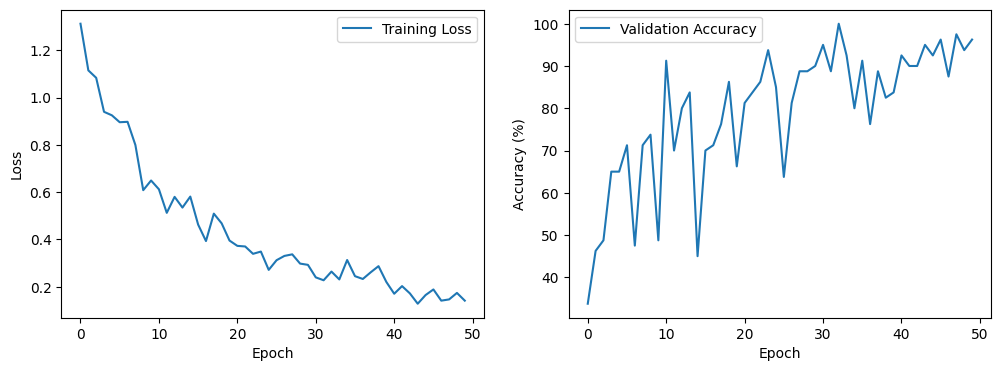

Epoch 1, Loss: 1.369, Val Acc: 31.25%
Epoch 2, Loss: 1.123, Val Acc: 36.25%
Epoch 3, Loss: 1.014, Val Acc: 53.75%
Epoch 4, Loss: 0.938, Val Acc: 68.75%
Epoch 5, Loss: 0.893, Val Acc: 66.25%
Epoch 6, Loss: 0.800, Val Acc: 52.50%
Epoch 7, Loss: 0.724, Val Acc: 62.50%
Epoch 8, Loss: 0.646, Val Acc: 71.25%
Epoch 9, Loss: 0.661, Val Acc: 63.75%
Epoch 10, Loss: 0.650, Val Acc: 77.50%
Epoch 11, Loss: 0.574, Val Acc: 83.75%
Epoch 12, Loss: 0.562, Val Acc: 63.75%
Epoch 13, Loss: 0.470, Val Acc: 90.00%
Epoch 14, Loss: 0.509, Val Acc: 57.50%
Epoch 15, Loss: 0.500, Val Acc: 75.00%
Epoch 16, Loss: 0.496, Val Acc: 61.25%
Epoch 17, Loss: 0.430, Val Acc: 88.75%
Epoch 18, Loss: 0.456, Val Acc: 93.75%
Epoch 19, Loss: 0.424, Val Acc: 81.25%
Epoch 20, Loss: 0.467, Val Acc: 92.50%
Epoch 21, Loss: 0.344, Val Acc: 68.75%
Epoch 22, Loss: 0.379, Val Acc: 63.75%
Epoch 23, Loss: 0.405, Val Acc: 86.25%
Epoch 24, Loss: 0.391, Val Acc: 87.50%
Epoch 25, Loss: 0.326, Val Acc: 86.25%
Epoch 26, Loss: 0.253, Val Acc: 88

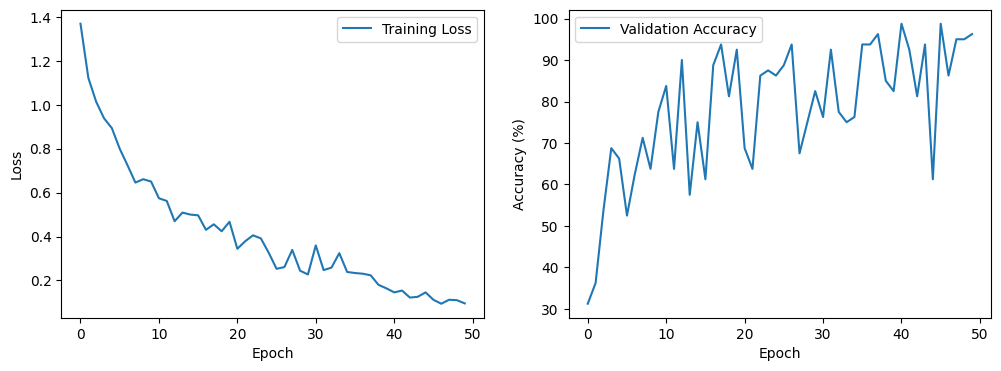

Epoch 1, Loss: 1.291, Val Acc: 23.75%
Epoch 2, Loss: 0.982, Val Acc: 60.00%
Epoch 3, Loss: 0.959, Val Acc: 62.50%
Epoch 4, Loss: 0.962, Val Acc: 60.00%
Epoch 5, Loss: 0.809, Val Acc: 70.00%
Epoch 6, Loss: 0.840, Val Acc: 57.50%
Epoch 7, Loss: 0.727, Val Acc: 70.00%
Epoch 8, Loss: 0.766, Val Acc: 83.75%
Epoch 9, Loss: 0.708, Val Acc: 62.50%
Epoch 10, Loss: 0.682, Val Acc: 50.00%
Epoch 11, Loss: 0.593, Val Acc: 83.75%
Epoch 12, Loss: 0.592, Val Acc: 58.75%
Epoch 13, Loss: 0.542, Val Acc: 70.00%
Epoch 14, Loss: 0.534, Val Acc: 72.50%
Epoch 15, Loss: 0.529, Val Acc: 81.25%
Epoch 16, Loss: 0.441, Val Acc: 86.25%
Epoch 17, Loss: 0.439, Val Acc: 83.75%
Epoch 18, Loss: 0.432, Val Acc: 52.50%
Epoch 19, Loss: 0.490, Val Acc: 77.50%
Epoch 20, Loss: 0.466, Val Acc: 66.25%
Epoch 21, Loss: 0.399, Val Acc: 72.50%
Epoch 22, Loss: 0.328, Val Acc: 81.25%
Epoch 23, Loss: 0.362, Val Acc: 50.00%
Epoch 24, Loss: 0.379, Val Acc: 87.50%
Epoch 25, Loss: 0.316, Val Acc: 81.25%
Epoch 26, Loss: 0.318, Val Acc: 91

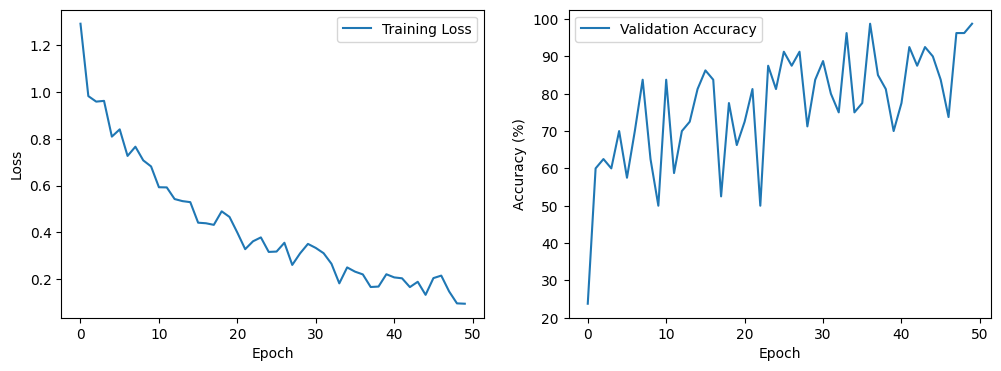

Epoch 1, Loss: 1.336, Val Acc: 25.00%
Epoch 2, Loss: 1.128, Val Acc: 55.00%
Epoch 3, Loss: 0.903, Val Acc: 51.25%
Epoch 4, Loss: 0.967, Val Acc: 52.50%
Epoch 5, Loss: 0.797, Val Acc: 81.25%
Epoch 6, Loss: 0.790, Val Acc: 65.00%
Epoch 7, Loss: 0.633, Val Acc: 60.00%
Epoch 8, Loss: 0.590, Val Acc: 60.00%
Epoch 9, Loss: 0.592, Val Acc: 76.25%
Epoch 10, Loss: 0.566, Val Acc: 63.75%
Epoch 11, Loss: 0.585, Val Acc: 78.75%
Epoch 12, Loss: 0.513, Val Acc: 85.00%
Epoch 13, Loss: 0.439, Val Acc: 77.50%
Epoch 14, Loss: 0.479, Val Acc: 88.75%
Epoch 15, Loss: 0.552, Val Acc: 72.50%
Epoch 16, Loss: 0.469, Val Acc: 81.25%
Epoch 17, Loss: 0.466, Val Acc: 66.25%
Epoch 18, Loss: 0.429, Val Acc: 90.00%
Epoch 19, Loss: 0.409, Val Acc: 75.00%
Epoch 20, Loss: 0.390, Val Acc: 91.25%
Epoch 21, Loss: 0.494, Val Acc: 72.50%
Epoch 22, Loss: 0.439, Val Acc: 85.00%
Epoch 23, Loss: 0.362, Val Acc: 88.75%
Epoch 24, Loss: 0.328, Val Acc: 40.00%
Epoch 25, Loss: 0.377, Val Acc: 80.00%
Epoch 26, Loss: 0.300, Val Acc: 86

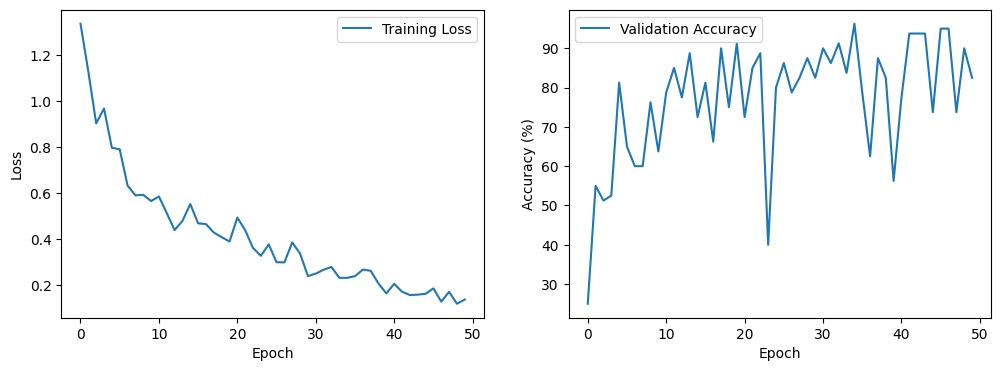


Training Set Performance:
Accuracy: 0.994, Precision: 0.994, Recall: 0.994, F1: 0.994

Validation Set Performance:
Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000

Test Set Performance:
Accuracy: 0.980, Precision: 0.980, Recall: 0.980, F1: 0.980


In [ ]:
# 4. Ensemble Training and Evaluation
reset_seed = lambda seed: [torch.manual_seed(seed), np.random.seed(seed), random.seed(seed)]
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
models = []
history_list = []
for _ in range(5):
    model = VGG_BatchNormTorch(in_channels=1, out_features=5).cuda()
    optimizer = optim.Adam(model.parameters())
    best_state, history = train(model, train_dataloader, val_dataloader, criterion, optimizer, n_epoch=50)
    model.load_state_dict(best_state)
    models.append(model)
    history_list.append(history)
    plot_training_history(history)

print("\nTraining Set Performance:")
train_acc, train_prec, train_rec, train_f1, _, _, _, _ = evaluate_ensemble(models, train_dataloader)
print(f"Accuracy: {train_acc:.3f}, Precision: {train_prec:.3f}, Recall: {train_rec:.3f}, F1: {train_f1:.3f}")

print("\nValidation Set Performance:")
val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_ensemble(models, val_dataloader)
print(f"Accuracy: {val_acc:.3f}, Precision: {val_prec:.3f}, Recall: {val_rec:.3f}, F1: {val_f1:.3f}")

print("\nTest Set Performance:")
test_acc, test_prec, test_rec, test_f1, misclassified_images, misclassified_labels, misclassified_predictions, correctly_classified_images = evaluate_ensemble(models, test_dataloader)
print(f"Accuracy: {test_acc:.3f}, Precision: {test_prec:.3f}, Recall: {test_rec:.3f}, F1: {test_f1:.3f}")

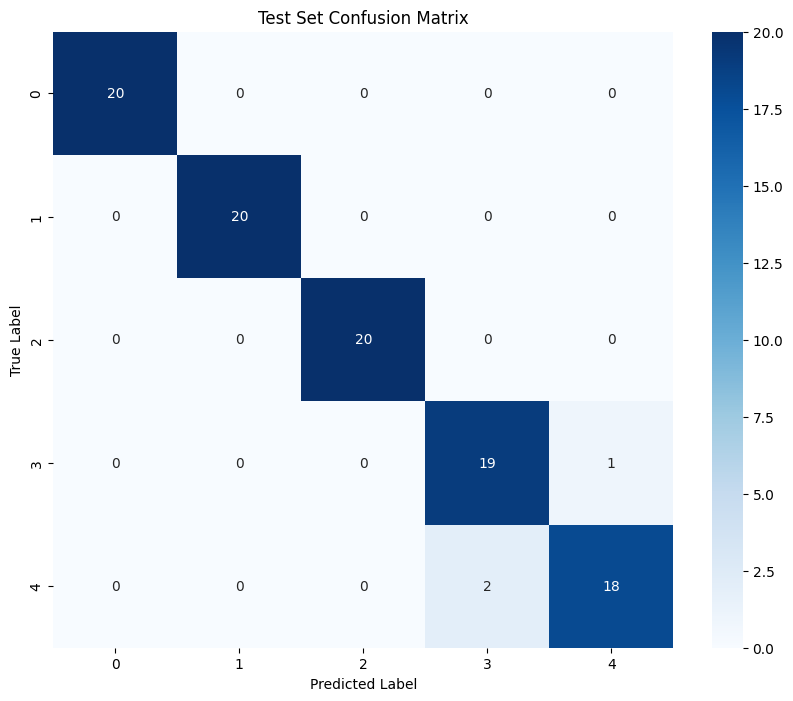

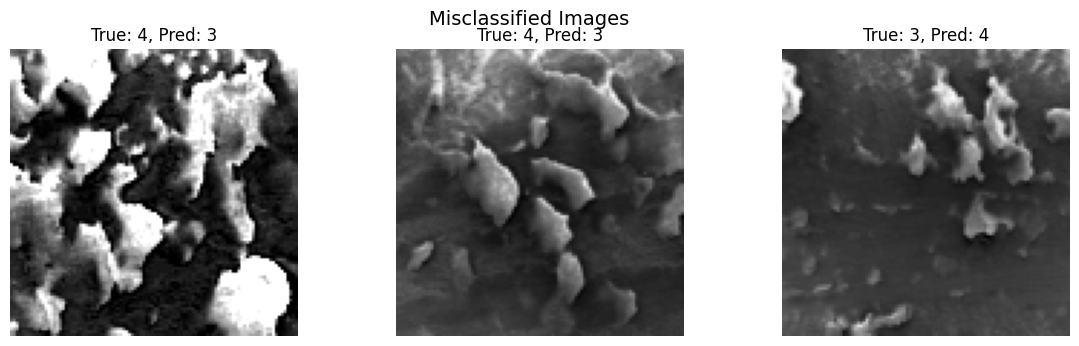

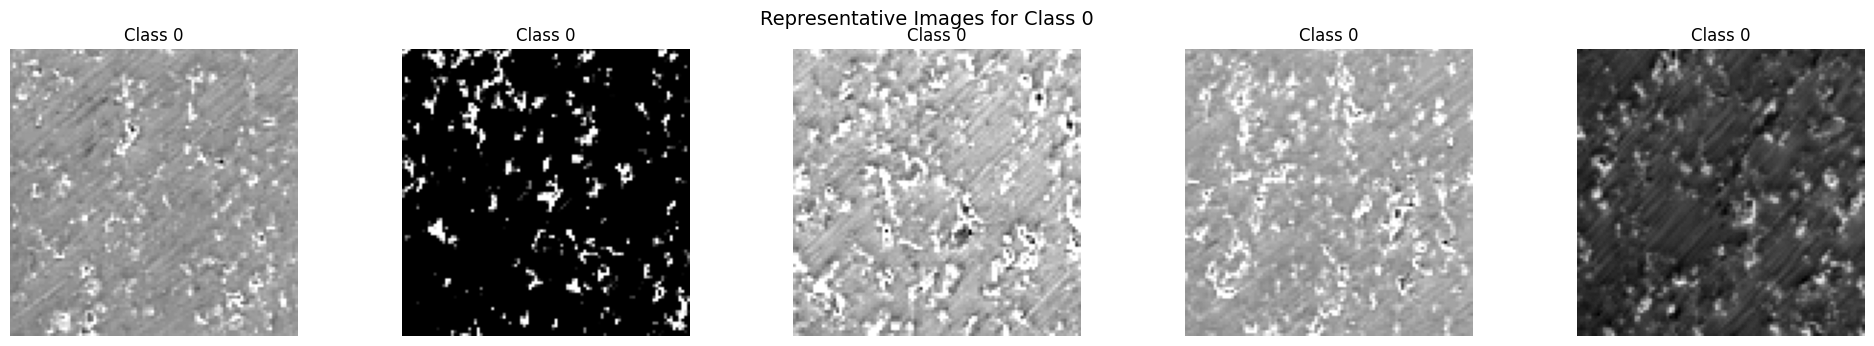

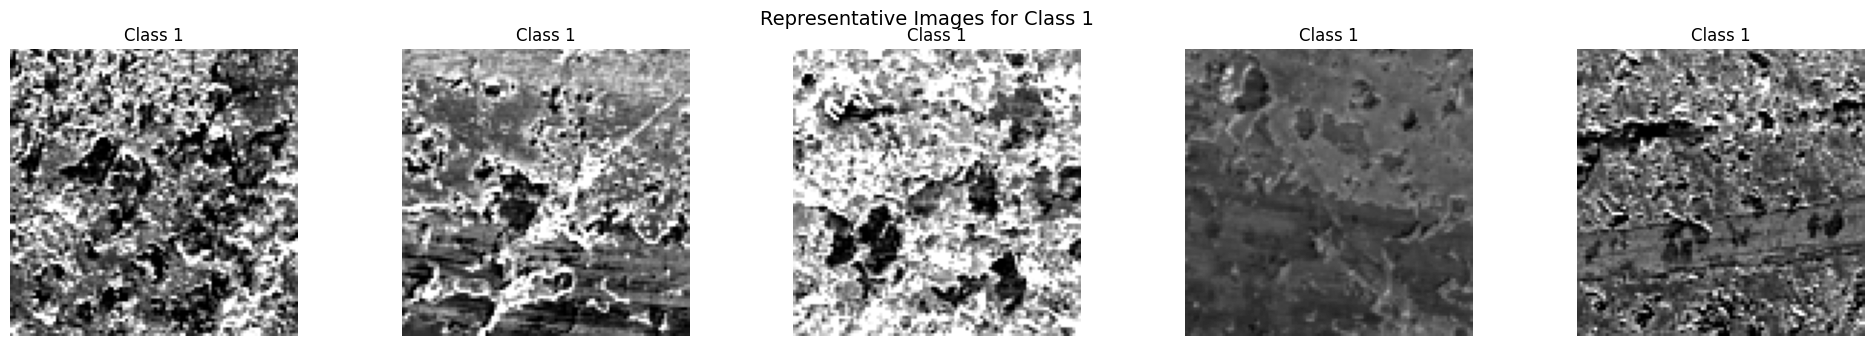

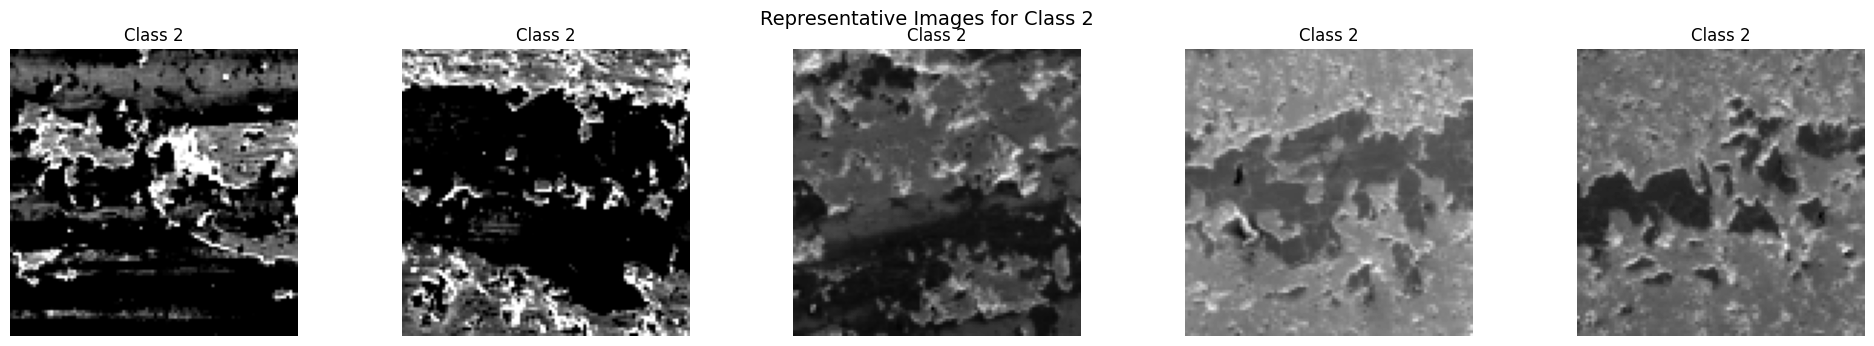

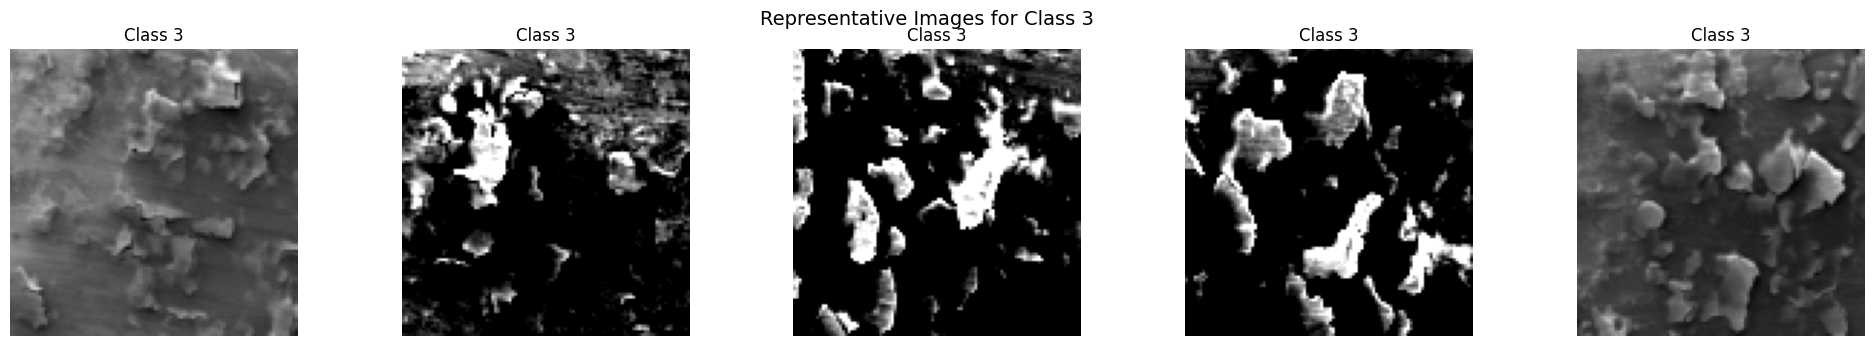

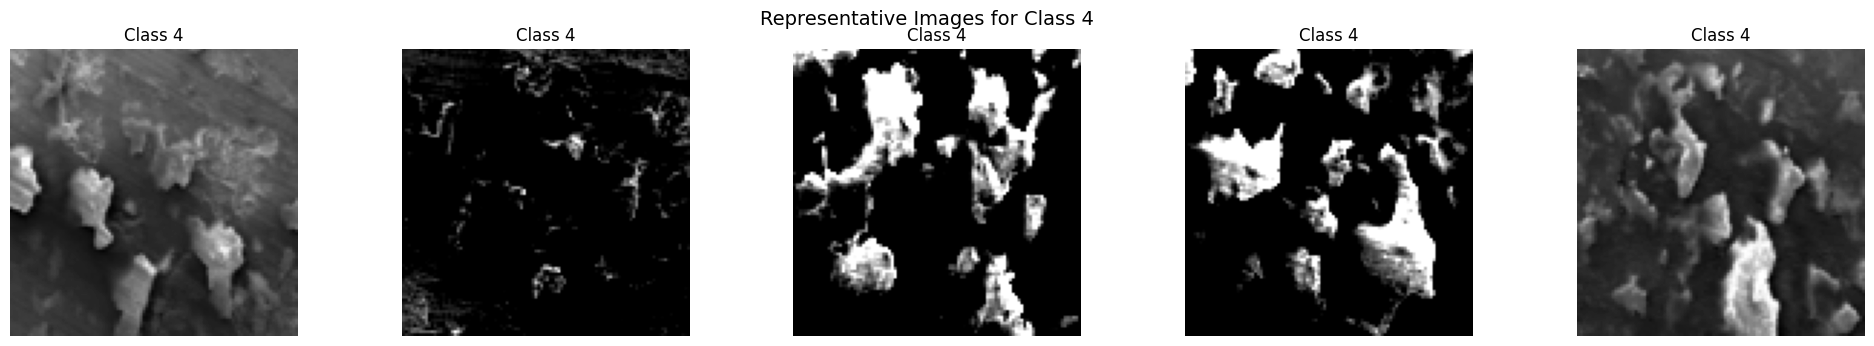

array([[20,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0, 20,  0,  0],
       [ 0,  0,  0, 19,  1],
       [ 0,  0,  0,  2, 18]])

In [ ]:
# Confusion Matrix Visualization
plot_confusion_matrix(models, test_dataloader, "Test Set Confusion Matrix")

In [ ]:
# Individual Model Performance
for idx, model in enumerate(models):
    acc, prec, rec, f1, _, _, _, _ = evaluate_ensemble([model], test_dataloader)
    print(f"\nModel {idx + 1} Performance:")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Model 1 Performance:
Accuracy: 0.960, Precision: 0.964, Recall: 0.960, F1: 0.960

Model 2 Performance:
Accuracy: 0.940, Precision: 0.943, Recall: 0.940, F1: 0.940

Model 3 Performance:
Accuracy: 0.980, Precision: 0.982, Recall: 0.980, F1: 0.980

Model 4 Performance:
Accuracy: 0.940, Precision: 0.943, Recall: 0.940, F1: 0.941

Model 5 Performance:
Accuracy: 0.950, Precision: 0.956, Recall: 0.950, F1: 0.949
